1. Running scrublet
2. Run model
3. Model selection
4. Clustering & visualization
5. Topic binarization & QC
6. Differential Accessibility Regions (DARs)
7. Gene activity
8. Label transfer 

# Environment

In [1]:
# Standard library imports
import os
import gc
import sys
import pickle
import importlib

# Data manipulation imports
import pandas as pd
import scanpy as sc
import scrublet as scr
import polars as pl
import numpy as np

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# pycisTopic imports
import pycisTopic
from pycisTopic.lda_models import run_cgs_models_mallet, evaluate_models
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk, peak_calling
from pycisTopic.iterative_peak_calling import get_consensus_peaks
from pycisTopic.plotting.qc_plot import plot_sample_stats, plot_barcode_stats
from pycisTopic.topic_qc import compute_topic_metrics, plot_topic_qc, topic_annotation
from pycisTopic.utils import fig2img
from pycisTopic.topic_binarization import binarize_topics
from pycisTopic.cistopic_class import create_cistopic_object_from_fragments, merge
from pycisTopic.qc import get_barcodes_passing_qc_for_sample
from pycisTopic.clust_vis import (
    find_clusters,
    run_umap,
    run_tsne,
    plot_metadata,
    plot_topic,
    cell_topic_heatmap
)

from pycisTopic.diff_features import (
    impute_accessibility,
    normalize_scores,
    find_highly_variable_features,
    find_diff_features
)
from pycisTopic.clust_vis import plot_imputed_features
import pyranges as pr
from pycisTopic.gene_activity import get_gene_activity
import numpy as np
from pycisTopic.utils import region_names_to_coordinates

import pyranges as pr
from pycisTopic.gene_activity import get_gene_activity
from pycisTopic.label_transfer import label_transfer

importlib.reload(pycisTopic)
from pycisTopic import *
pycisTopic.__version__

sys.path.insert(0, "/home/michal.kubacki/Githubs/Re-MEND/code/External_Datasets/GeneSet_Derivation/Herring_scenic/helpers")
import config
importlib.reload(config)
from config import *
n_cpus = 32

In [3]:
#################################################################
reference = "hg19"


# neurons_set = "all_excitatory"
# neurons_set = "all_inhibitory"
neurons_set = "all_excitatory_all_ages"
# neurons_set = "all_inhibitory_all_ages"

cells_dict = {
    "all_inhibitory"            :   ['SST', 'VIP', 'MGE_dev'],
    "all_inhibitory_all_ages"   :   ['VIP', 'SST', 'PV', 'MGE_dev'],
    "all_excitatory"            :   ['L5-6_TLE4', 'L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'PN_dev'],
    "all_excitatory_all_ages"   :   ['L5-6_TLE4', 'L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'PN_dev']
}

ages_dict = {
    "all_inhibitory"            :   ['1m','3m','6m','10m','1y','2y','4y','ga22','ga24'],
    "all_inhibitory_all_ages"   :   ['1m','3m','6m','10m','1y','2y','4y','6y','10y','16y','20y','40y','ga22','ga24'],
    "all_excitatory"            :   ['1m','3m','6m','10m','1y','2y','4y','ga22','ga24'],
    "all_excitatory_all_ages"   :   ['1m','3m','6m','10m','1y','2y','4y','6y','10y','16y','20y','40y','ga22','ga24']
}

out_dir, in_dir, root_dir, tmp_dir, data_folder = set_output_folders(reference, neurons_set)

sel_celltypes  = cells_dict[neurons_set]
sel_ages = ages_dict[neurons_set]

#################################################################

root_dir: /group/testa/michal.kubacki/herring
out_dir: /group/testa/michal.kubacki/herring/output_hg19_all_excitatory
in_dir: /group/testa/michal.kubacki/herring/data
tmp_dir: /group/testa/michal.kubacki/herring/tmp


In [4]:
fragments_dict = select_files(reference, selected_fragments = sel_ages)

All fragments: {'ga22': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138510_RL2366_ga22_snATAC_fragments.tsv.gz', '1y': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138526_RL2209_1y_snATAC_fragments.tsv.gz', '14y': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138542_RL2372_14y_snATAC_fragments.tsv.gz', 'ga24': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138512_RL2207_ga24_snATAC_fragments.tsv.gz', '2y': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138529_RL1784_2y_snATAC_fragments.tsv.gz', '16y': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138544_RL1785_16y_snATAC_fragments.tsv.gz', '1m': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138515_RL2367_1m_snATAC_fragments.tsv.gz', '4y': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138532_RL2210_4y_snATAC_fragments.tsv.gz', '20y': '/group/testa/michal.kubacki/herring/data/GSE168408_RAW/GSM5138548_RL2085_20y_snATAC_fragment

# Load file

In [4]:
file_path = os.path.join(out_dir, "cistopic_obj.pkl")

with open(file_path, "rb") as file:
    cistopic_obj = pickle.load(file)

In [33]:
cistopic_obj.cell_data.head()

total_fragments_in_peaks_count  nMonoFrags  \
ATTTGTCCATAGATAG-1-1m                            3978      3656.0   
TAGCACACATTTCTTG-1-1m                            5043         NaN   
GTTATGGCAAACCCTA-1-1m                            9500         NaN   
CTCTCGAAGTTATGAG-1-1m                            4139         NaN   
GCTCACTTCCAAACCA-1-1m                           13023         NaN   

                       tss_enrichment  TSSEnrichment             barcode  \
ATTTGTCCATAGATAG-1-1m        1.851727         15.633  ATTTGTCCATAGATAG-1   
TAGCACACATTTCTTG-1-1m        1.928305            NaN  TAGCACACATTTCTTG-1   
GTTATGGCAAACCCTA-1-1m        1.862601            NaN  GTTATGGCAAACCCTA-1   
CTCTCGAAGTTATGAG-1-1m        1.960423            NaN  CTCTCGAAGTTATGAG-1   
GCTCACTTCCAAACCA-1-1m        2.084320            NaN  GCTCACTTCCAAACCA-1   

                       duplication_ratio  pdf_values_for_duplication_ratio  \
ATTTGTCCATAGATAG-1-1m           0.186538                          0.792464   
TAGCACACATTTCTTG-1-1m           0.147946                          1.360023   
GTTATGGCAAACCCTA-1-1m           0.194741                          0.626418   
CTCTCGAAGTTATGAG-1-1m           0.223244                          0.201394   
GCTCACTTCCAAACCA-1-1m           0.226429                          0.151420   

                       BlacklistRatio  \
ATTTGTCCATAGATAG-1-1m        0.005707   
TAGCACACATTTCTTG-1-1m             NaN   
GTTATGGCAAACCCTA-1-1m             NaN   
CTCTCGAAGTTATGAG-1-1m             NaN   
GCTCACTTCCAAACCA-1-1m             NaN   

                       pdf_values_for_fraction_of_fragments_in_peaks  \
ATTTGTCCATAGATAG-1-1m                                       0.114913   
TAGCACACATTTCTTG-1-1m                                       0.380106   
GTTATGGCAAACCCTA-1-1m                                       0.055935   
CTCTCGAAGTTATGAG-1-1m                                       0.465188   
GCTCACTTCCAAACCA-1-1m                                       0.169987   

                       unique_fragments_in_peaks_count  ...  ReadsInBlacklist  \
ATTTGTCCATAGATAG-1-1m                             3134  ...              76.0   
TAGCACACATTTCTTG-1-1m                             4178  ...               NaN   
GTTATGGCAAACCCTA-1-1m                             7463  ...               NaN   
CTCTCGAAGTTATGAG-1-1m                             3090  ...               NaN   
GCTCACTTCCAAACCA-1-1m                             9870  ...               NaN   

                       pdf_values_for_tss_enrichment  DoubletScore  \
ATTTGTCCATAGATAG-1-1m                       0.070243      9.237125   
TAGCACACATTTCTTG-1-1m                       0.068753           NaN   
GTTATGGCAAACCCTA-1-1m                       0.073943           NaN   
CTCTCGAAGTTATGAG-1-1m                       0.054337           NaN   
GCTCACTTCCAAACCA-1-1m                       0.017637           NaN   

                                       predictedCell  \
ATTTGTCCATAGATAG-1-1m  TTCTGTAGTAGTGCGA-RL1777_2d_v3   
TAGCACACATTTCTTG-1-1m                            NaN   
GTTATGGCAAACCCTA-1-1m                            NaN   
CTCTCGAAGTTATGAG-1-1m                            NaN   
GCTCACTTCCAAACCA-1-1m                            NaN   

                       log10_total_fragments_in_peaks_count  cisTopic_nr_frag  \
ATTTGTCCATAGATAG-1-1m                              3.599774              3215   
TAGCACACATTTCTTG-1-1m                              3.702775              4273   
GTTATGGCAAACCCTA-1-1m                              3.977769              7632   
CTCTCGAAGTTATGAG-1-1m                              3.617000              3158   
GCTCACTTCCAAACCA-1-1m                              4.114744             10071   

                           FRIP predictedScore  Doublet_scores_fragments  \
ATTTGTCCATAGATAG-1-1m  0.582339       0.686586                  0.081481   
TAGCACACATTTCTTG-1-1m       NaN            NaN                  0.216129   
GTTATGGCAAACCCTA-1-1m       NaN           

# Running scrublet

Preprocessing...


/home/michal.kubacki/.conda/envs/scenicplus/lib/python3.11/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 3.3%
Estimated detectable doublet fraction = 30.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.7%
Elapsed time: 39.7 seconds
Detected doublet rate = 13.3%
Estimated detectable doublet fraction = 59.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 22.5%


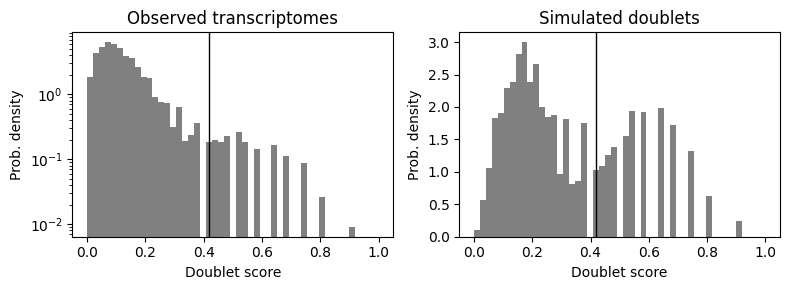

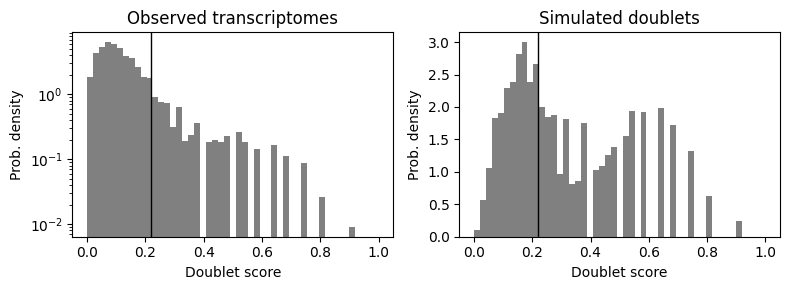

In [34]:
scrub = scr.Scrublet(cistopic_obj.fragment_matrix.T, expected_doublet_rate=0.1)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
scrub.plot_histogram();
scrub.call_doublets(threshold=0.22)
scrub.plot_histogram();
scrublet = pd.DataFrame([scrub.doublet_scores_obs_, scrub.predicted_doublets_], columns=cistopic_obj.cell_names, index=['Doublet_scores_fragments', 'Predicted_doublets_fragments']).T

In [35]:
cistopic_obj.add_cell_data(scrublet, split_pattern = '-')
sum(cistopic_obj.cell_data.Predicted_doublets_fragments == True)

Columns ['Predicted_doublets_fragments', 'Doublet_scores_fragments'] will be overwritten


1465

In [37]:
# Remove doublets
singlets = cistopic_obj.cell_data[cistopic_obj.cell_data.Predicted_doublets_fragments == False].index.tolist()
# Subset cisTopic object
cistopic_obj_noDBL = cistopic_obj.subset(singlets, copy=True, split_pattern='-')
print(cistopic_obj_noDBL)

CistopicObject from project cisTopic_merge with n_cells × n_regions = 9575 × 333565


In [38]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

# Run models

In [40]:
file_path = os.path.join(out_dir, "cistopic_obj.pkl")

with open(file_path, "rb") as file:
    cistopic_obj = pickle.load(file)

In [41]:
%%script false --no-raise-error

os.environ['MALLET_MEMORY'] = '200G'
# Configure path Mallet
mallet_path="/scratch/michal.kubacki/herring/Mallet-202108/bin/mallet"
# Run models
models=run_cgs_models_mallet(
    cistopic_obj,
    n_topics=[25, 30, 35, 40, 45, 50],
    n_cpu=n_cpus,
    n_iter=500,
    random_state=555,
    alpha=50,
    alpha_by_topic=True,
    eta=0.1,
    eta_by_topic=False,
    tmp_path="/tmp",
    save_path="/tmp",
    mallet_path=mallet_path,
)

2024-05-31 13:20:35,736 cisTopic     INFO     Formatting input to corpus
2024-05-31 13:20:36,222 cisTopic     INFO     Running model with 20 topics
2024-05-31 13:20:36,223 LDAMalletWrapper INFO     Serializing temporary corpus to /tmp/corpus.txt
2024-05-31 13:20:47,856 LDAMalletWrapper INFO     Converting temporary corpus to MALLET format with: /scratch/michal.kubacki/herring/Mallet-202108/bin/mallet import-file --preserve-case --keep-sequence --token-regex \S+ --input /tmp/corpus.txt --output /tmp/corpus.mallet
2024-05-31 13:21:07,422 LDAMalletWrapper INFO     Training MALLET LDA with: /scratch/michal.kubacki/herring/Mallet-202108/bin/mallet train-topics --input /tmp/corpus.mallet --num-topics 20 --alpha 50 --beta 0.1 --optimize-interval 0 --num-threads 32 --output-state /tmp/deb13c_state.mallet.gz --output-doc-topics /tmp/deb13c_doctopics.txt --output-topic-keys /tmp/deb13c_topickeys.txt --num-iterations 500 --inferencer-filename /tmp/deb13c_inferencer.mallet --doc-topics-threshold 0

In [42]:
%%script false --no-raise-error

pickle.dump(
    models,
    open(os.path.join(out_dir, "models_new.pkl"), "wb")
)

# Model selection

In [17]:
models = pickle.load(open(os.path.join(out_dir, "models.pkl"), "rb"))

/home/michal.kubacki/.conda/envs/scenicplus/lib/python3.11/site-packages/pycisTopic/lda_models.py:1123: RuntimeWarning: invalid value encountered in divide
  arun_2010_rescale = (arun_2010_negative - min(arun_2010_negative)) / (
/home/michal.kubacki/.conda/envs/scenicplus/lib/python3.11/site-packages/pycisTopic/lda_models.py:1146: RuntimeWarning: invalid value encountered in divide
  Cao_Juan_2009_rescale = (
/home/michal.kubacki/.conda/envs/scenicplus/lib/python3.11/site-packages/pycisTopic/lda_models.py:1170: RuntimeWarning: invalid value encountered in divide
  Mimno_2011_rescale = (Mimno_2011 - min(Mimno_2011)) / (
/home/michal.kubacki/.conda/envs/scenicplus/lib/python3.11/site-packages/pycisTopic/lda_models.py:1187: RuntimeWarning: invalid value encountered in divide
  loglikelihood_rescale = (loglikelihood - min(loglikelihood)) / (


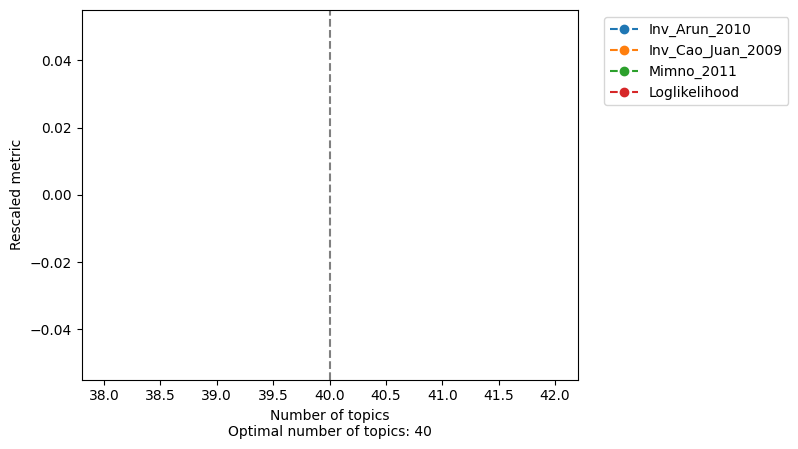

In [18]:
model = evaluate_models(
    models,
    select_model = 40,
    return_model = True
)

In [19]:
model.topic_region.head()

Topic1        Topic2    Topic3    Topic4  \
chr15:70146055-70146555   0.000000  0.000000e+00  0.000000  0.000000   
chr5:106349396-106349896  0.000016  0.000000e+00  0.000000  0.000004   
chr1:160989831-160990331  0.000000  4.608393e-06  0.000000  0.000000   
chr9:20668889-20669389    0.000000  9.216785e-07  0.000000  0.000000   
chr17:17614116-17614616   0.000001  0.000000e+00  0.000004  0.000004   

                                Topic5    Topic6        Topic7    Topic8  \
chr15:70146055-70146555   2.930612e-07  0.000000  8.339331e-07  0.000000   
chr5:106349396-106349896  0.000000e+00  0.000000  0.000000e+00  0.000000   
chr1:160989831-160990331  0.000000e+00  0.000000  0.000000e+00  0.000023   
chr9:20668889-20669389    0.000000e+00  0.000000  0.000000e+00  0.000000   
chr17:17614116-17614616   0.000000e+00  0.000006  0.000000e+00  0.000000   

                            Topic9  Topic10  ...   Topic31  Topic32   Topic33  \
chr15:70146055-70146555   0.000001      0.0  ...  0.000005      0.0  0.000000   
chr5:106349396-106349896  0.000000      0.0  ...  0.000018      0.0  0.000000   
chr1:160989831-160990331  0.000015      0.0  ...  0.000000      0.0  0.000005   
chr9:20668889-20669389    0.000000      0.0  ...  0.000005      0.0  0.000003   
chr17:17614116-17614616   0.000000      0.0  ...  0.000000      0.0  0.000000   

                          Topic34  Topic35   Topic36  Topic37   Topic38  \
chr15:70146055-70146555       0.0      0.0  0.000000      0.0  0.000002   
chr5:106349396-106349896      0.0      0.0  0.000000      0.0  0.000002   
chr1:160989831-160990331      0.0      0.0  0.000004      0.0  0.000000   
chr9:20668889-20669389        0.0      0.0  0.000004      0.0  0.000004   
chr17:17614116-17614616       0.0      0.0  0.000008      0.0  0.000000   

                           Topic39   Topic40  
chr15:70146055-70146555   0.000000  0.000006  
chr5:106349396-106349896  0.000000  0.000000  
chr1:160989831-160990331  0.000017  0.000012  
chr9:20668889-20669389    0.000000  0.000003  
chr17:17614116-17614616   0.000074  0.000000  

[5 rows x 40 columns]

In [20]:
model.topic_region.shape

(329439, 40)

In [21]:
cistopic_obj.region_names[:10]

['chr15:70146055-70146555',
 'chr5:106349396-106349896',
 'chr1:160989831-160990331',
 'chr9:20668889-20669389',
 'chr17:17614116-17614616',
 'chr3:171758516-171759016',
 'chr5:126436866-126437366',
 'chr3:110433365-110433865',
 'chr10:34402674-34403174',
 'chr4:15885135-15885635']

In [22]:
len(cistopic_obj.region_names)

329439

In [24]:
cistopic_obj.add_LDA_model(model)

In [25]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

# Clustering and visualization

In [26]:
cistopic_obj = pickle.load(open(os.path.join(out_dir, "cistopic_obj.pkl"), "rb"))

In [27]:
find_clusters(
    cistopic_obj,
    target  = 'cell',
    k = 10,
    res = [0.6, 1.2, 3],
    prefix = 'pycisTopic_',
    scale = True,
    split_pattern = '-'
)

2024-06-19 12:39:23,930 cisTopic     INFO     Finding neighbours


In [28]:
run_umap(
    cistopic_obj,
    target  = 'cell', scale=True)

2024-06-19 12:39:28,945 cisTopic     INFO     Running UMAP


/home/michal.kubacki/.conda/envs/scenicplus/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [29]:
run_tsne(
    cistopic_obj,
    target  = 'cell', scale=True)

2024-06-19 12:39:55,919 cisTopic     INFO     Running TSNE


In [30]:
cistopic_obj.cell_data.columns

Index(['cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc',
       'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank',
       'total_fragments_count', 'log10_total_fragments_count',
       'unique_fragments_count', 'log10_unique_fragments_count',
       'total_fragments_in_peaks_count',
       'log10_total_fragments_in_peaks_count',
       'unique_fragments_in_peaks_count',
       'log10_unique_fragments_in_peaks_count',
       'fraction_of_fragments_in_peaks', 'duplication_count',
       'duplication_ratio', 'nucleosome_signal', 'tss_enrichment',
       'pdf_values_for_tss_enrichment',
       'pdf_values_for_fraction_of_fragments_in_peaks',
       'pdf_values_for_duplication_ratio', 'barcode', 'TSSEnrichment',
       'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio',
       'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags',
       'nDiFrags', 'DoubletScore', 'DoubletEnrichment', 'BlacklistRatio',
       'Clusters', 'predictedCell', 'predic

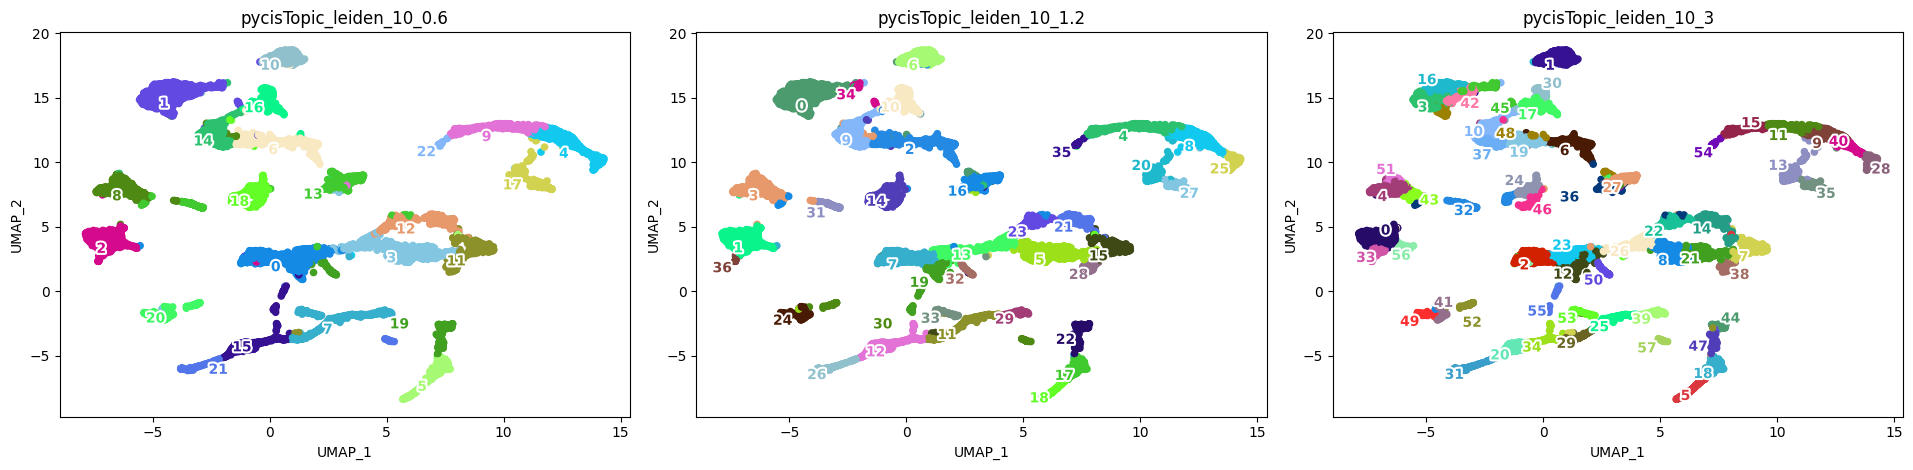

In [31]:
plot_metadata(
    cistopic_obj,
    reduction_name='UMAP',
    variables=['pycisTopic_leiden_10_0.6', 'pycisTopic_leiden_10_1.2', 'pycisTopic_leiden_10_3'],
    target='cell', num_columns=4,
    text_size=10,
    dot_size=20)

In [32]:
annot_dict = {}
for resolution in [0.6, 1.2, 3]:
    annot_dict[f"pycisTopic_leiden_10_{resolution}"] = {}
    for cluster in set(cistopic_obj.cell_data[f"pycisTopic_leiden_10_{resolution}"]):
        counts = cistopic_obj.cell_data.loc[
            cistopic_obj.cell_data.loc[cistopic_obj.cell_data[f"pycisTopic_leiden_10_{resolution}"] == cluster].index, "major_clust"].value_counts()
        if not counts.empty:
            annot_dict[f"pycisTopic_leiden_10_{resolution}"][cluster] = f"{counts.index[counts.argmax()]}({cluster})"
        else:
            annot_dict[f"pycisTopic_leiden_10_{resolution}"][cluster] = f"N/A({cluster})"

In [33]:
annot_dict

{'pycisTopic_leiden_10_0.6': {'18': 'L2-3_CUX2(18)',
  '11': 'L5-6_TLE4(11)',
  '21': 'L5-6_THEMIS(21)',
  '19': 'L5-6_TLE4(19)',
  '7': 'L2-3_CUX2(7)',
  '8': 'L5-6_THEMIS(8)',
  '3': 'L5-6_TLE4(3)',
  '17': 'L5-6_TLE4(17)',
  '1': 'L4_RORB(1)',
  '10': 'N/A(10)',
  '12': 'L4_RORB(12)',
  '16': 'L5-6_TLE4(16)',
  '13': 'L5-6_THEMIS(13)',
  '4': 'PN_dev(4)',
  '6': 'L2-3_CUX2(6)',
  '9': 'L4_RORB(9)',
  '0': 'L2-3_CUX2(0)',
  '15': 'L2-3_CUX2(15)',
  '20': 'L5-6_TLE4(20)',
  '14': 'L4_RORB(14)',
  '5': 'PN_dev(5)',
  '2': 'L4_RORB(2)',
  '22': 'L4_RORB(22)'},
 'pycisTopic_leiden_10_1.2': {'18': 'PN_dev(18)',
  '11': 'L2-3_CUX2(11)',
  '21': 'N/A(21)',
  '19': 'L5-6_TLE4(19)',
  '7': 'L2-3_CUX2(7)',
  '30': 'L5-6_TLE4(30)',
  '27': 'PN_dev(27)',
  '25': 'PN_dev(25)',
  '23': 'L4_RORB(23)',
  '26': 'L5-6_THEMIS(26)',
  '3': 'L5-6_THEMIS(3)',
  '1': 'L4_RORB(1)',
  '17': 'PN_dev(17)',
  '8': 'PN_dev(8)',
  '10': 'L5-6_TLE4(10)',
  '12': 'L2-3_CUX2(12)',
  '16': 'L5-6_THEMIS(16)',
  '35': 

In [34]:
for resolution in [0.6, 1.2, 3]:
    cistopic_obj.cell_data[f'pycisTopic_leiden_10_{resolution}'] = [
        annot_dict[f'pycisTopic_leiden_10_{resolution}'][x] for x in cistopic_obj.cell_data[f'pycisTopic_leiden_10_{resolution}'].tolist()
    ]

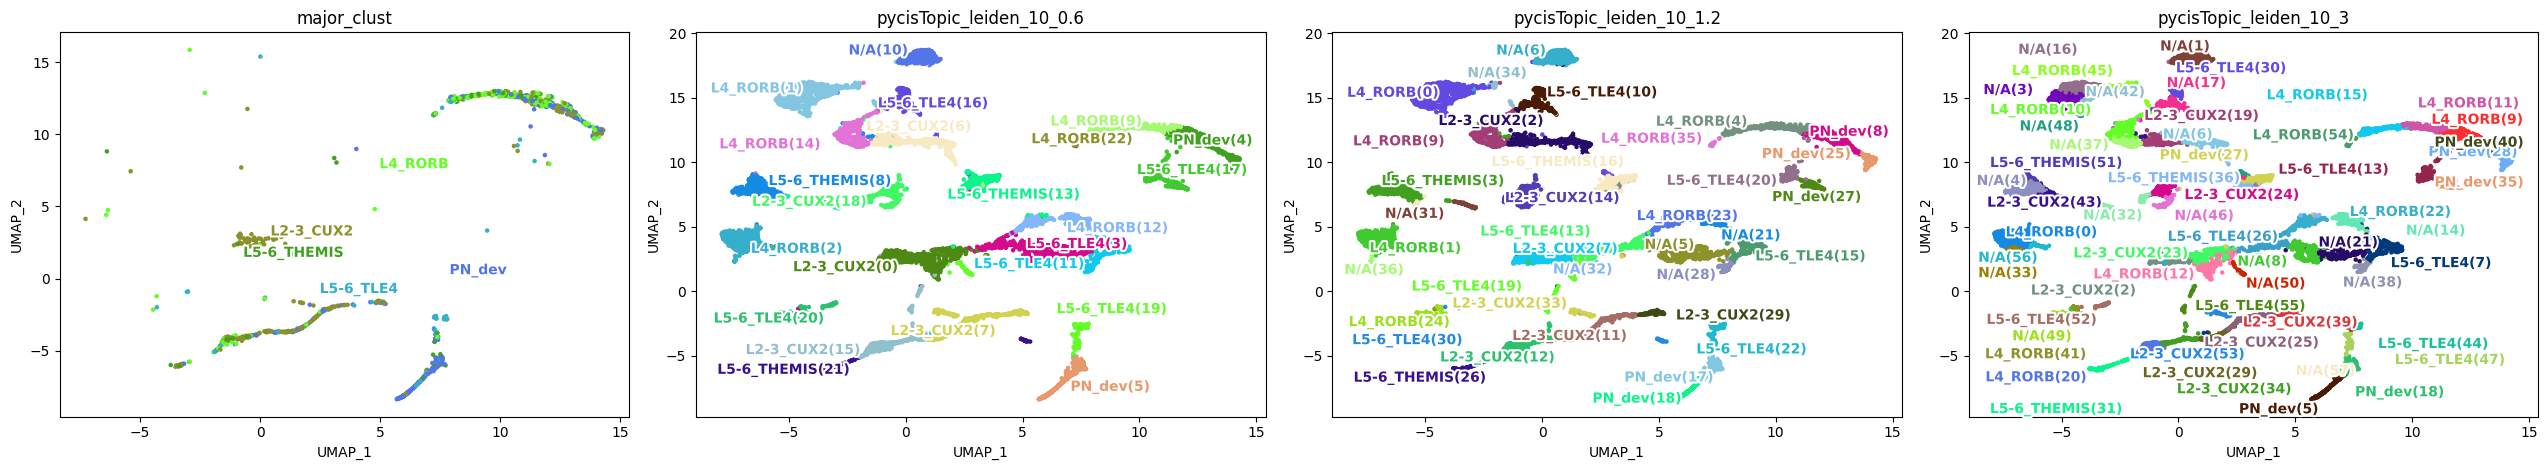

In [35]:
plot_metadata(
    cistopic_obj,
    reduction_name='UMAP',
    variables=['major_clust', 'pycisTopic_leiden_10_0.6', 'pycisTopic_leiden_10_1.2', 'pycisTopic_leiden_10_3'],
    target='cell', num_columns=4,
    text_size=10,
    dot_size=5)

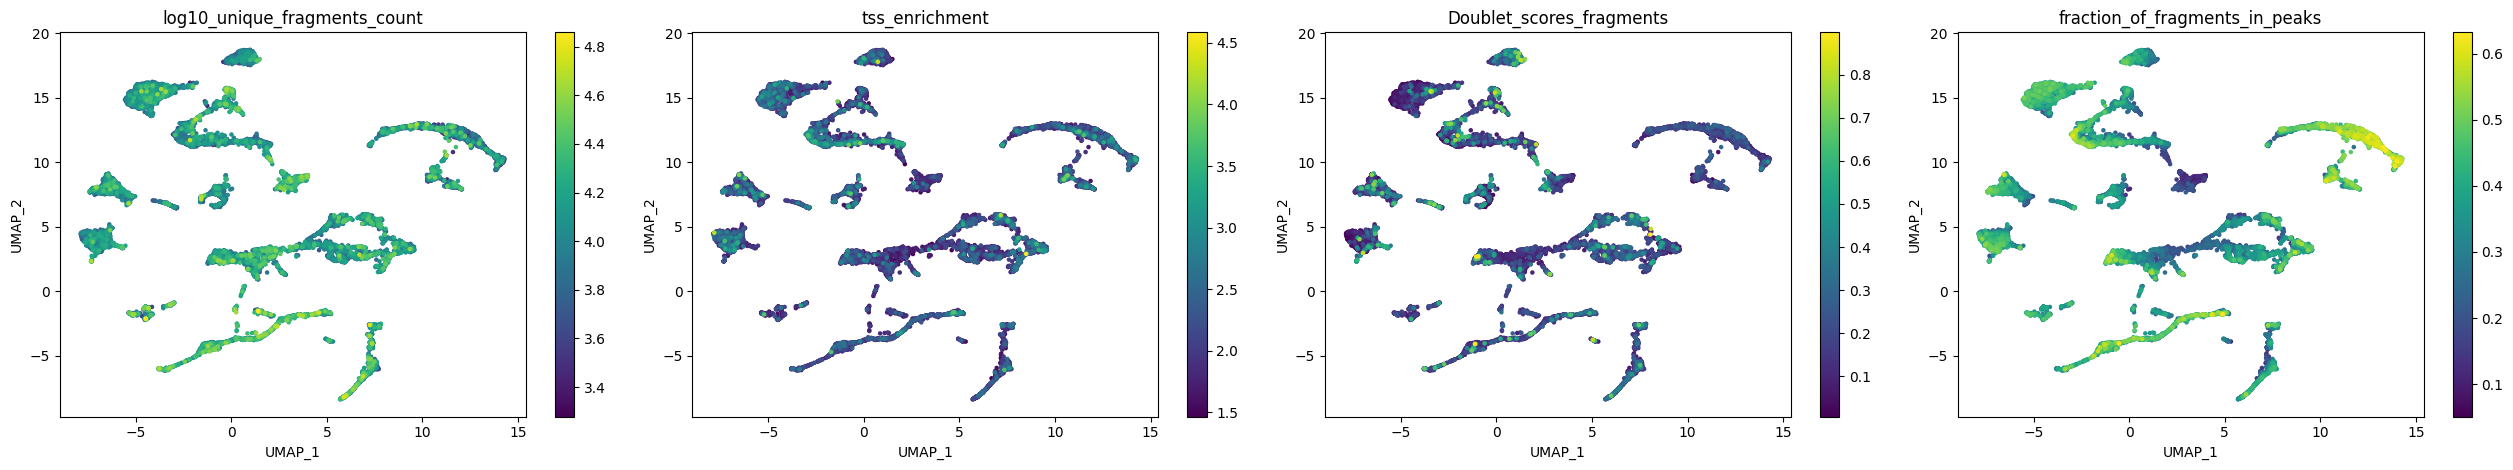

In [36]:
plot_metadata(
    cistopic_obj,
    reduction_name='UMAP',
    variables=['log10_unique_fragments_count', 'tss_enrichment', 'Doublet_scores_fragments', 'fraction_of_fragments_in_peaks'],
    target='cell', num_columns=4,
    text_size=10,
    dot_size=5)

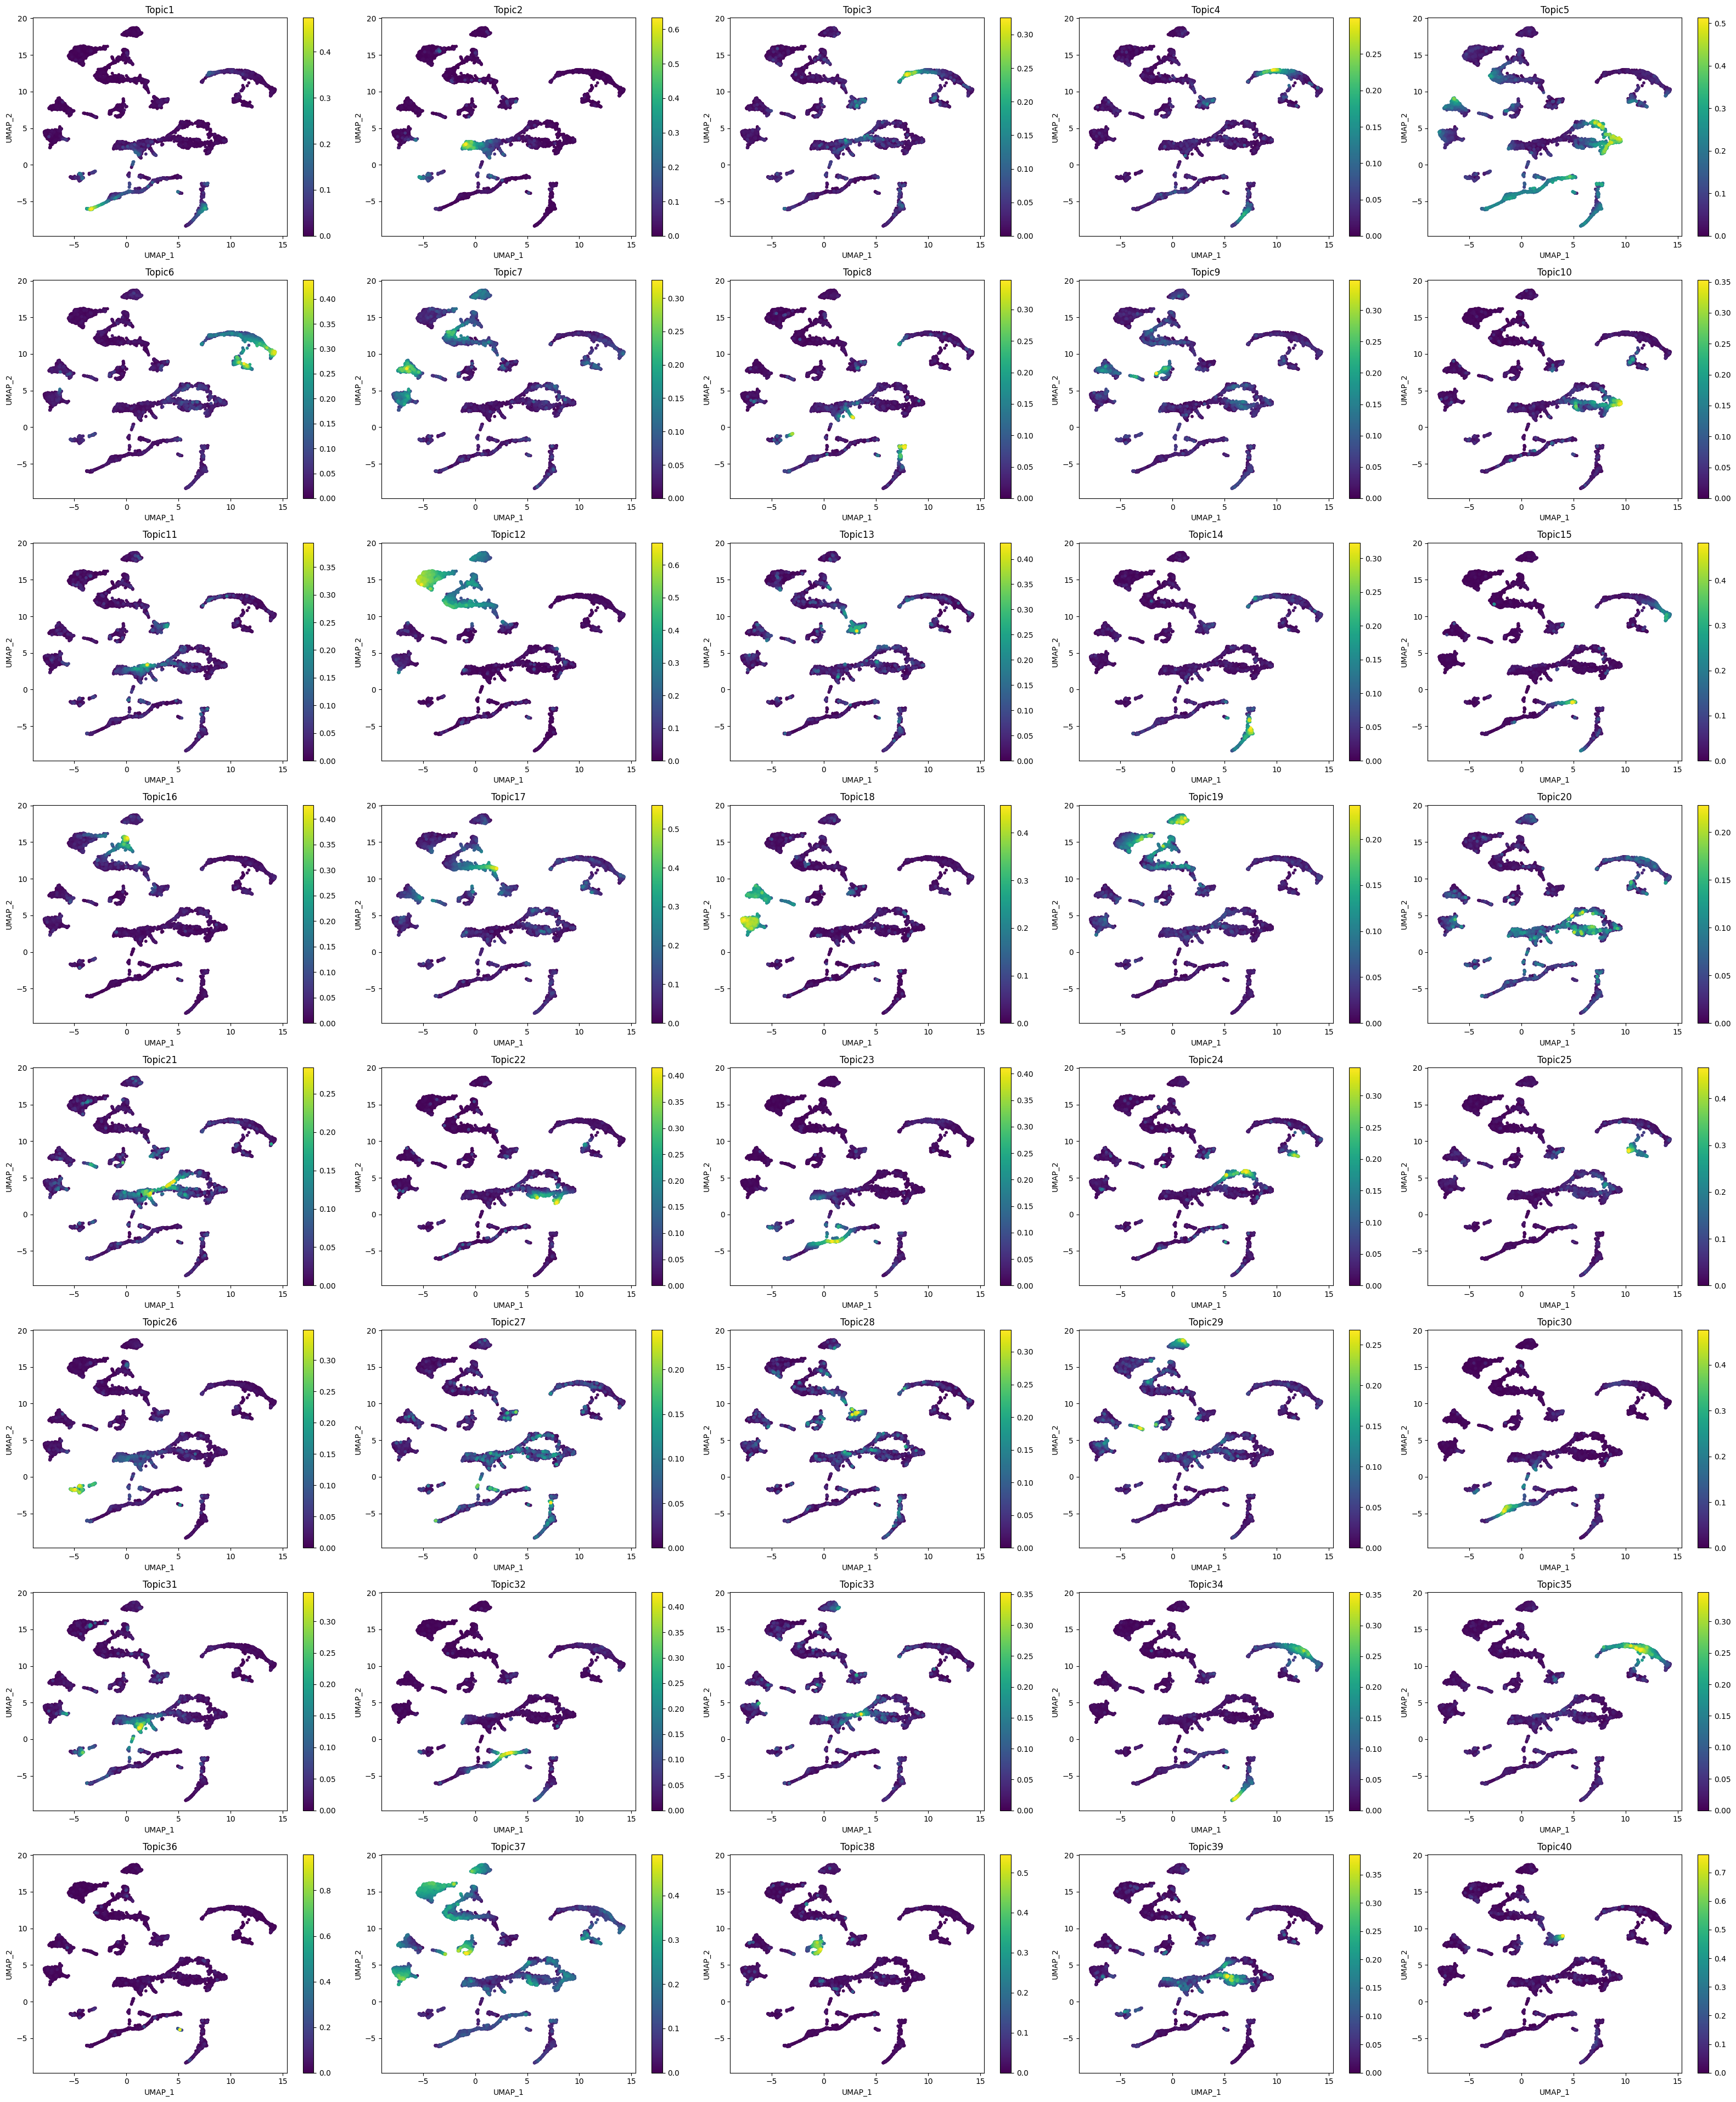

In [37]:
plot_topic(
    cistopic_obj,
    reduction_name = 'UMAP',
    target = 'cell',
    num_columns=5
)

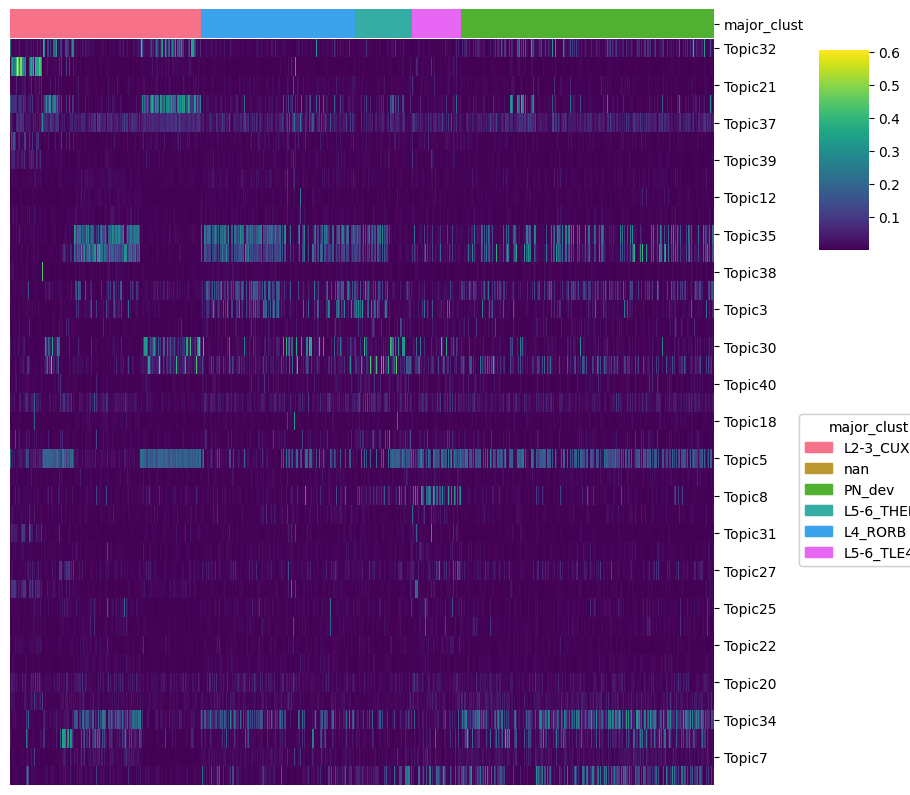

In [38]:

color_dict = {'major_clust': {}}
unique_values = cistopic_obj.cell_data['major_clust'].unique()
colors = sns.color_palette('husl', len(unique_values)).as_hex()
for value, color in zip(unique_values, colors):
    color_dict['major_clust'][value] = color

cell_topic_heatmap(
    cistopic_obj,
    variables=['major_clust'],
    scale=False,
    legend_loc_x=1.0,
    legend_loc_y=-1.2,
    legend_dist_y=-1,
    figsize=(10, 10),
    color_dictionary=color_dict
)

# Topic binarization & QC

In [39]:
region_bin_topics_top_3k = binarize_topics(
    cistopic_obj, method='ntop', ntop = 3_000,
    plot=False, num_columns=5
)

In [40]:
region_bin_topics_otsu = binarize_topics(
    cistopic_obj, method='otsu',
    plot=False, num_columns=5
)

In [41]:
binarized_cell_topic = binarize_topics(
    cistopic_obj,
    target='cell',
    method='li',
    plot=False,
    num_columns=5, nbins=100)

In [42]:
topic_qc_metrics = compute_topic_metrics(cistopic_obj)

In [43]:
fig_dict={}
fig_dict['CoherenceVSAssignments']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['AssignmentsVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Log10_Assignments', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSRegions_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Regions_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSMarginal_dist']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Marginal_topic_dist', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSGini_index']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Gini_index', var_color='Gini_index', plot=False, return_fig=True)

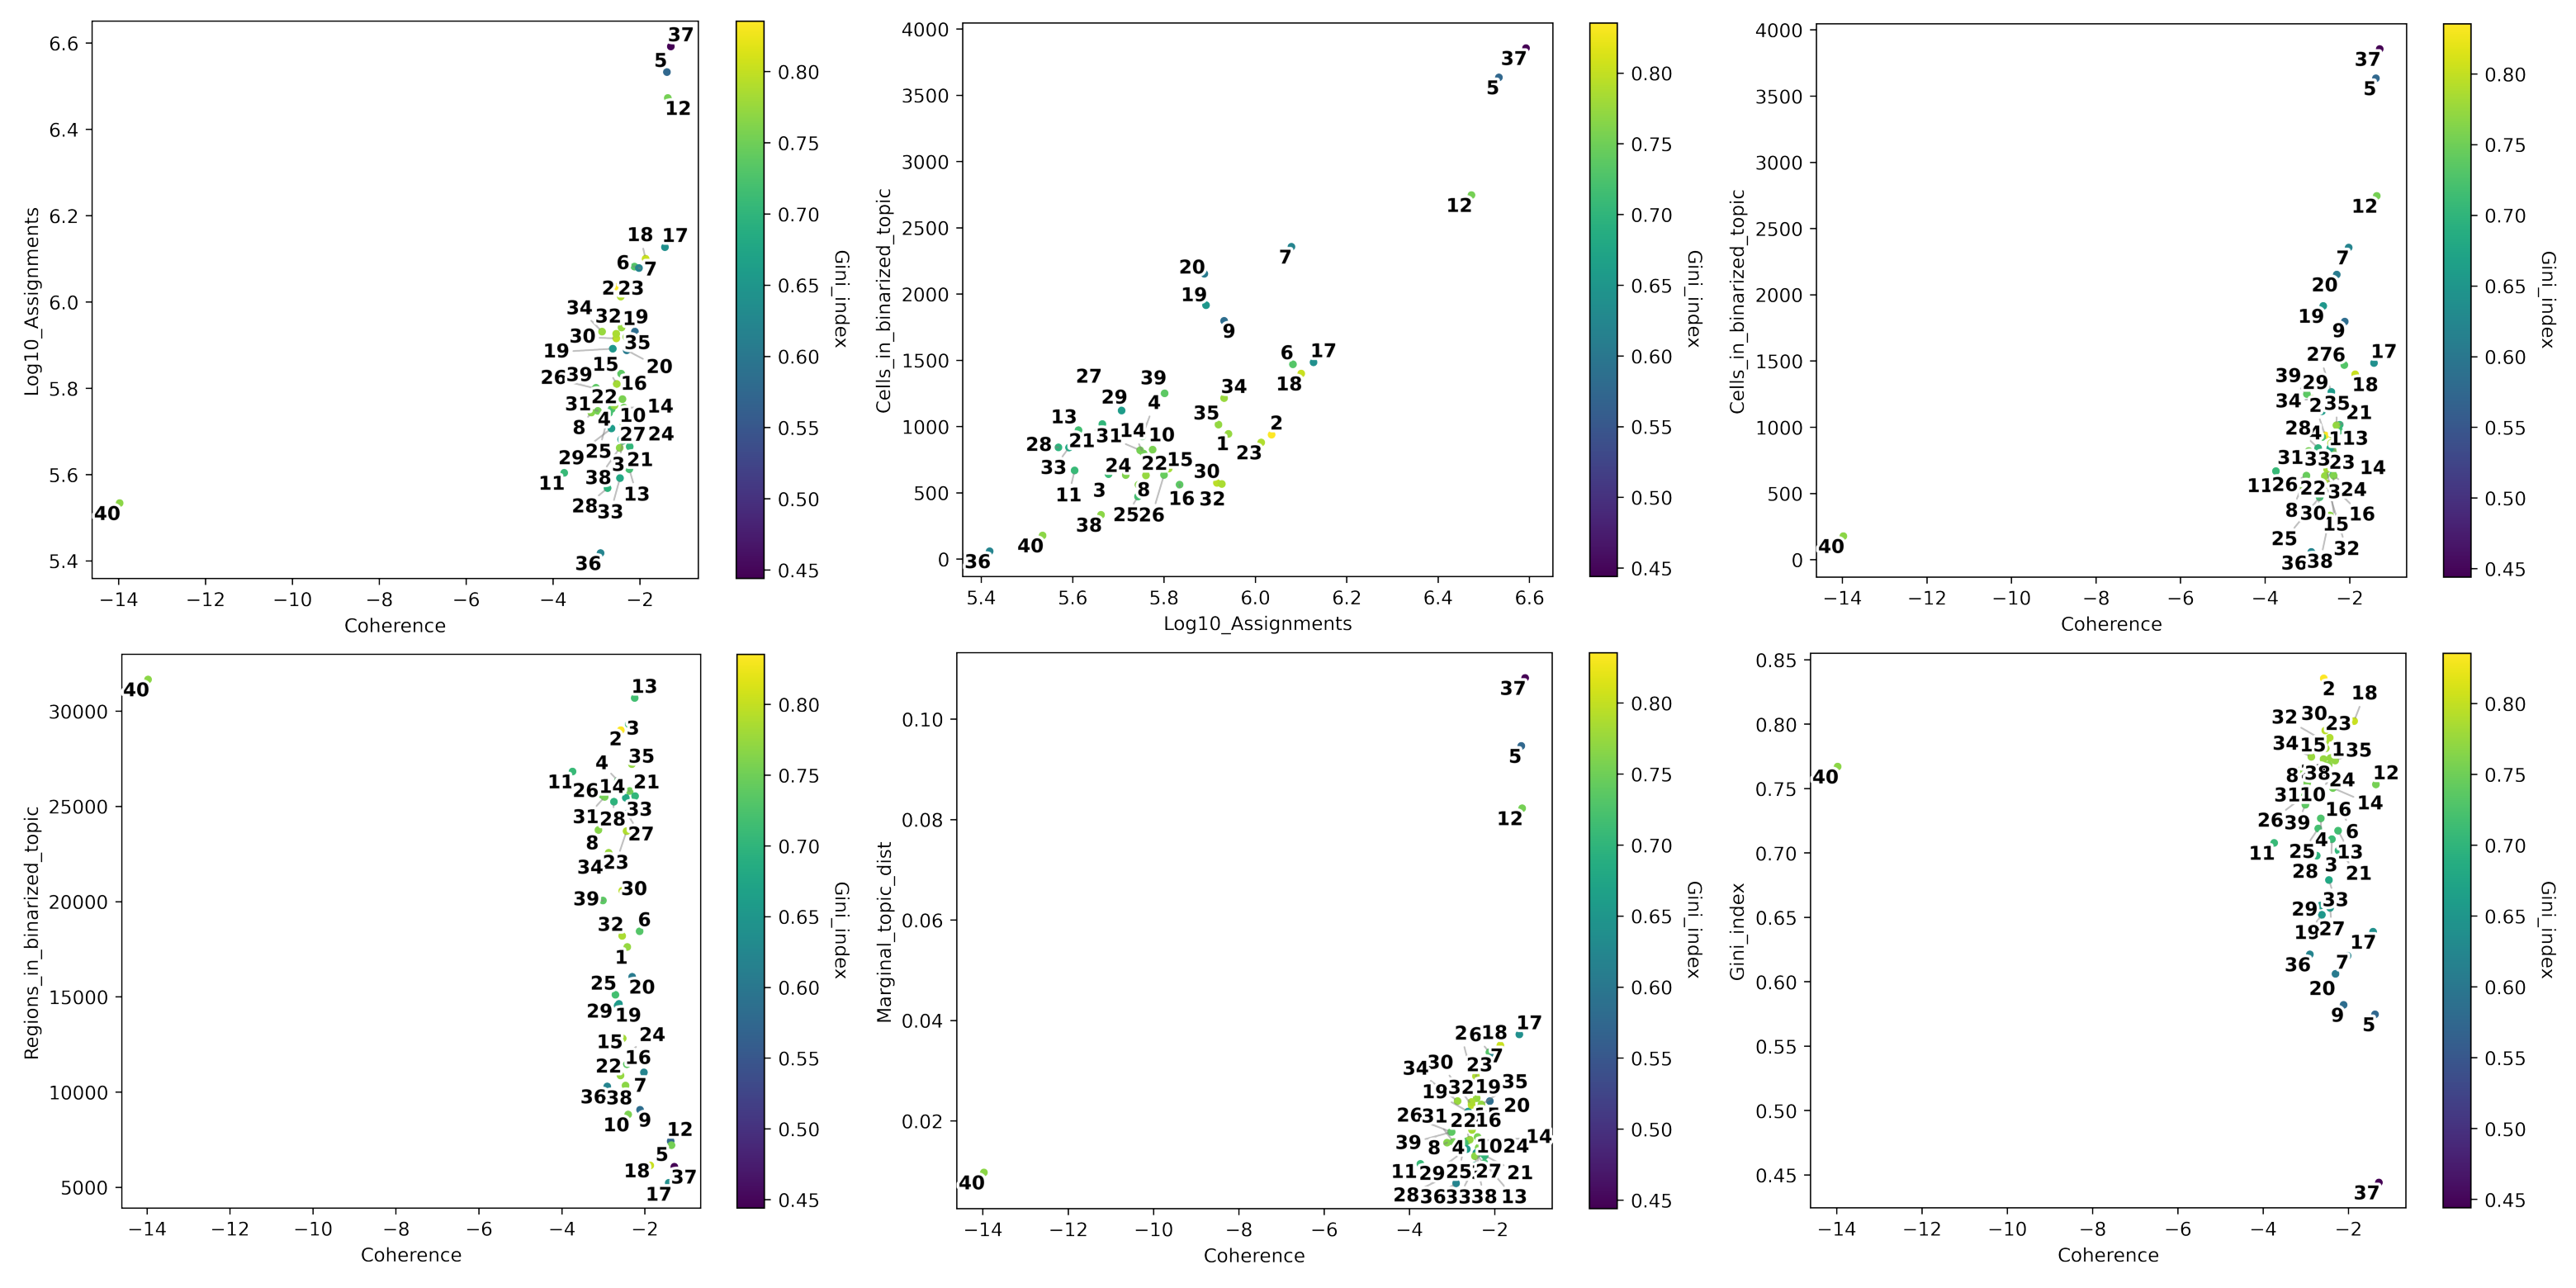

In [44]:
# Plot topic stats in one figure
fig=plt.figure(figsize=(40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0, hspace=-0.70)
plt.show()

In [45]:
topic_annot = topic_annotation(
    cistopic_obj,
    annot_var='major_clust',
    binarized_cell_topic=binarized_cell_topic,
    general_topic_thr = 0.2
)

/home/michal.kubacki/.conda/envs/scenicplus/lib/python3.11/site-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: divide by zero encountered in scalar divide
  zstat = value / std


In [46]:
topic_annot

major_clust  \
Topic1   L4_RORB, L2-3_CUX2, PN_dev, L5-6_THEMIS, L5-6_...   
Topic2                                           L2-3_CUX2   
Topic3                     L4_RORB, L5-6_THEMIS, L5-6_TLE4   
Topic4             L4_RORB, L2-3_CUX2, PN_dev, L5-6_THEMIS   
Topic5           L2-3_CUX2, PN_dev, L5-6_THEMIS, L5-6_TLE4   
Topic6             L4_RORB, L2-3_CUX2, PN_dev, L5-6_THEMIS   
Topic7                                                       
Topic8                              L5-6_THEMIS, L5-6_TLE4   
Topic9                                                       
Topic10                                                      
Topic11                                                      
Topic12                                                      
Topic13                                        L5-6_THEMIS   
Topic14            L4_RORB, PN_dev, L5-6_THEMIS, L5-6_TLE4   
Topic15                         L4_RORB, L2-3_CUX2, PN_dev   
Topic16                                                      
Topic17                                                      
Topic18                                                      
Topic19                                                      
Topic20                                                      
Topic21                                                      
Topic22                                                      
Topic23                             L2-3_CUX2, L5-6_THEMIS   
Topic24                                                      
Topic25                                                      
Topic26                                          L2-3_CUX2   
Topic27                     PN_dev, L5-6_THEMIS, L5-6_TLE4   
Topic28                                        L5-6_THEMIS   
Topic29                                                      
Topic30         L4_RORB, L2-3_CUX2, L5-6_THEMIS, L5-6_TLE4   
Topic31                                                      
Topic32                                  L2-3_CUX2, PN_dev   
Topic33                                                      
Topic34            L4_RORB, L2-3_CUX2, PN_dev, L5-6_THEMIS   
Topic35            L4_RORB, L2-3_CUX2, PN_dev, L5-6_THEMIS   
Topic36                                                      
Topic37                                                      
Topic38                                                      
Topic39                                                      
Topic40                                                      

        Ratio_cells_in_topic Ratio_group_in_population  is_general  
Topic1               0.08566                  0.108774       False  
Topic2              0.085116                   0.02955       False  
Topic3              0.058104                  0.040156       False  
Topic4              0.083938                  0.101251       False  
Topic5              0.329496                  0.084935        True  
Topic6              0.133249                  0.101251       False  
Topic7              0.213651                       0.0        True  
Topic8              0.050852                  0.016316       False  
Topic9               0.16298                       0.0       False  
Topic10             0.074873                       0.0       False  
Topic11             0.060642                       0.0       False  
Topic12             0.249003                       0.0        True  
Topic13             0.088198                  0.008793       False  
Topic14             0.072154                  0.079224       False  
Topic15             0.061911                  0.092458       False  
Topic16             0.050943                       0.0       False  
Topic17             0.134608                       0.0       False  
Topic18             0.126904                       0.0       False  
Topic19             0.173677                       0.0       False  
Topic20              0.19516                       0.0       False  
Topic21             0.092368                       0.0 

In [47]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

# Differentially Accessible Regions (DARs)

In [48]:
imputed_acc_obj = impute_accessibility(
    cistopic_obj,
    selected_cells=None,
    selected_regions=None,
    scale_factor=10**6
)

2024-06-19 12:42:06,013 cisTopic     INFO     Imputing region accessibility
2024-06-19 12:42:06,015 cisTopic     INFO     Impute region accessibility for regions 0-20000


2024-06-19 12:42:07,598 cisTopic     INFO     Impute region accessibility for regions 20000-40000
2024-06-19 12:42:09,080 cisTopic     INFO     Impute region accessibility for regions 40000-60000
2024-06-19 12:42:10,562 cisTopic     INFO     Impute region accessibility for regions 60000-80000
2024-06-19 12:42:12,043 cisTopic     INFO     Impute region accessibility for regions 80000-100000
2024-06-19 12:42:13,530 cisTopic     INFO     Impute region accessibility for regions 100000-120000
2024-06-19 12:42:15,022 cisTopic     INFO     Impute region accessibility for regions 120000-140000
2024-06-19 12:42:16,511 cisTopic     INFO     Impute region accessibility for regions 140000-160000
2024-06-19 12:42:17,995 cisTopic     INFO     Impute region accessibility for regions 160000-180000
2024-06-19 12:42:19,483 cisTopic     INFO     Impute region accessibility for regions 180000-200000
2024-06-19 12:42:20,971 cisTopic     INFO     Impute region accessibility for regions 200000-220000
2024-06

In [49]:
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)

2024-06-19 12:42:30,638 cisTopic     INFO     Normalizing imputed data
2024-06-19 12:42:49,374 cisTopic     INFO     Done!


In [50]:
variable_regions = find_highly_variable_features(
    normalized_imputed_acc_obj,
    min_disp = 0.05,
    min_mean = 0.0125,
    max_mean = 3,
    max_disp = np.inf,
    n_bins=20,
    n_top_features=None,
    plot=True
)

2024-06-19 12:42:49,417 cisTopic     INFO     Calculating mean
2024-06-19 12:42:52,607 cisTopic     INFO     Calculating variance


: 

: 

: 

In [ ]:
len(variable_regions)

86744

In [ ]:
file_path = os.path.join(out_dir, "find_diff_features_cistopic_obj.pkl")
with open(file_path, "wb") as file:
    pickle.dump(cistopic_obj, file)

file_path = os.path.join(out_dir, "find_diff_features_imputed_acc_obj.pkl")
with open(file_path, "wb") as file:
    pickle.dump(imputed_acc_obj, file)

file_path = os.path.join(out_dir, "find_diff_features_variable_regions.pkl")
with open(file_path, "wb") as file:
    pickle.dump(variable_regions, file)


In [ ]:
# file_path = os.path.join(out_dir, "find_diff_features_cistopic_obj.pkl")
# with open(file_path, "rb") as file:
#     cistopic_obj = pickle.load(file)

# file_path = os.path.join(out_dir, "find_diff_features_imputed_acc_obj.pkl")
# with open(file_path, "rb") as file:
#     imputed_acc_obj = pickle.load(file)

# file_path = os.path.join(out_dir, "find_diff_features_variable_regions.pkl")
# with open(file_path, "rb") as file:
#     variable_regions = pickle.load(file)

In [ ]:
markers_dict= find_diff_features(
    cistopic_obj,
    imputed_acc_obj,
    variable='major_clust',
    var_features=variable_regions,
    contrasts=None,
    adjpval_thr=0.05,
    log2fc_thr=np.log2(1.5),
    n_cpu=1,
    _temp_dir='/tmp',
    split_pattern = '-'
)

Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2024-06-01 07:23:25,656	INFO worker.py:1740 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


2024-06-01 07:24:06,446 cisTopic     INFO     Subsetting data for L2-3_CUX2 (325 of 11040)
2024-06-01 07:24:11,387 cisTopic     INFO     Computing p-value for L2-3_CUX2
2024-06-01 07:25:41,718 cisTopic     INFO     Computing log2FC for L2-3_CUX2
2024-06-01 07:25:43,544 cisTopic     INFO     L2-3_CUX2 done!
2024-06-01 07:25:43,547 cisTopic     INFO     Subsetting data for L4_RORB (263 of 11040)
2024-06-01 07:25:44,100 cisTopic     INFO     Computing p-value for L4_RORB
2024-06-01 07:26:36,159 cisTopic     INFO     Computing log2FC for L4_RORB
2024-06-01 07:26:36,326 cisTopic     INFO     L4_RORB done!
2024-06-01 07:26:36,331 cisTopic     INFO     Subsetting data for L5-6_THEMIS (97 of 11040)
2024-06-01 07:26:36,897 cisTopic     INFO     Computing p-value for L5-6_THEMIS
2024-06-01 07:27:30,129 cisTopic     INFO     Computing log2FC for L5-6_THEMIS
2024-06-01 07:27:30,285 cisTopic     INFO     L5-6_THEMIS done!
2024-06-01 07:27:30,290 cisTopic     INFO     Subsetting data for L5-6_TLE4 (

In [ ]:
print(markers_dict.keys())

dict_keys(['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'L5-6_TLE4', 'PN_dev'])


In [ ]:
# for x in ['L2-3_CUX2', 'L4_RORB', 'L5-6_THEMIS', 'PN_dev']:
#     print(f"Cell type: {x}")
#     print(markers_dict[x])
#     print("---")

In [ ]:
markers_dict['L2-3_CUX2'].head()

Log2FC  Adjusted_pval   Contrast
chr8:124993173-124993673  5.070237       0.000023  L2-3_CUX2
chr6:120968156-120968656  5.013949       0.000026  L2-3_CUX2
chr7:25680247-25680747    4.970336       0.000042  L2-3_CUX2
chr20:3435585-3436085     4.926936       0.000030  L2-3_CUX2
chr16:82057731-82058231   4.915801       0.000036  L2-3_CUX2

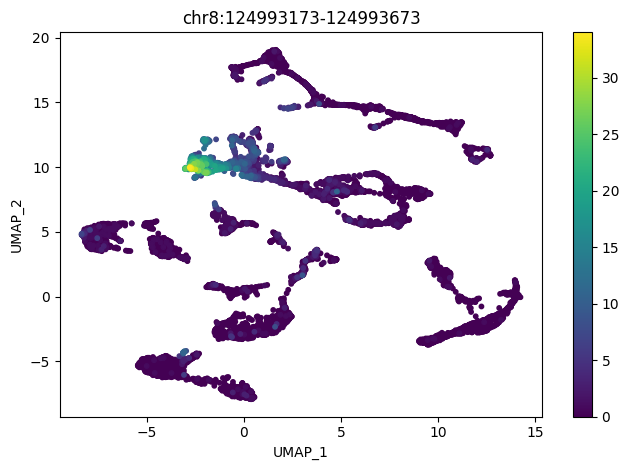

In [ ]:
plot_imputed_features(
    cistopic_obj,
    reduction_name='UMAP',
    imputed_data=imputed_acc_obj,
    features=[markers_dict[x].index.tolist()[0] for x in  ['L2-3_CUX2']],
    scale=False,
    num_columns=3
)

In [ ]:
print("Number of DARs found:")
print("---------------------")
for x in markers_dict:
    print(f"  {x}: {len(markers_dict[x])}")

Number of DARs found:
---------------------
  L2-3_CUX2: 14574
  L4_RORB: 9722
  L5-6_THEMIS: 9510
  L5-6_TLE4: 11646
  PN_dev: 4398


In [ ]:
os.makedirs(os.path.join(out_dir, "region_sets"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "region_sets", "Topics_otsu"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "region_sets", "Topics_top_3k"), exist_ok = True)
os.makedirs(os.path.join(out_dir, "region_sets", "DARs_cell_type"), exist_ok = True)

In [ ]:
for topic in region_bin_topics_otsu:
    region_names_to_coordinates(
        region_bin_topics_otsu[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_sets", "Topics_otsu", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [ ]:
for topic in region_bin_topics_top_3k:
    region_names_to_coordinates(
        region_bin_topics_top_3k[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_sets", "Topics_top_3k", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [ ]:
for cell_type in markers_dict:
    region_names_to_coordinates(
        markers_dict[cell_type].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_sets", "DARs_cell_type", f"{cell_type}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [ ]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

# Gene activity

In [ ]:
chromsizes = pd.read_table(os.path.join(out_dir, "qc", f"{reference}.chrom_sizes_and_alias.tsv"))
chromsizes

# ucsc     length               ensembl     refseq_id  \
0                    chr1  249250621                     1  NC_000001.10   
1                   chr10  135534747                    10  NC_000010.10   
2                   chr11  135006516                    11   NC_000011.9   
3   chr11_gl000202_random      40103   HSCHR11_RANDOM_CTG2   NT_113921.2   
4                   chr12  133851895                    12  NC_000012.11   
..                    ...        ...                   ...           ...   
88         chrUn_gl000247      36422  HSCHRUN_RANDOM_CTG40   NT_167241.1   
89         chrUn_gl000248      39786  HSCHRUN_RANDOM_CTG41   NT_167242.1   
90         chrUn_gl000249      38502  HSCHRUN_RANDOM_CTG42   NT_167243.1   
91                   chrX  155270560                     X  NC_000023.10   
92                   chrY   59373566                     Y   NC_000024.9   

    genbank_id  
0   CM000663.1  
1   CM000672.1  
2   CM000673.1  
3   GL000202.1  
4   CM000674.1  
..         ...  
88  GL000247.1  
89  GL000248.1  
90  GL000249.1  
91  CM000685.1  
92  CM000686.1  

[93 rows x 5 columns]

In [ ]:
chromsizes.rename({"# ucsc": "Chromosome", "length": "End"}, axis = 1, inplace = True)
chromsizes["Start"] = 0
chromsizes = pr.PyRanges(chromsizes[["Chromosome", "Start", "End"]])

In [ ]:
chromsizes

+----------------------+-----------+-----------+
| Chromosome           | Start     | End       |
| (category)           | (int32)   | (int32)   |
|----------------------+-----------+-----------|
| chr1                 | 0         | 249250621 |
| chr1_gl000191_random | 0         | 106433    |
| chr1_gl000192_random | 0         | 547496    |
| chr2                 | 0         | 243199373 |
| ...                  | ...       | ...       |
| chrUn_gl000248       | 0         | 39786     |
| chrUn_gl000249       | 0         | 38502     |
| chrX                 | 0         | 155270560 |
| chrY                 | 0         | 59373566  |
+----------------------+-----------+-----------+
Unstranded PyRanges object has 93 rows and 3 columns from 93 chromosomes.
For printing, the PyRanges was sorted on Chromosome.

In [ ]:
pr_annotation = pd.read_table(
        os.path.join(out_dir, "qc", "tss.bed")
    ).rename(
        {"Name": "Gene", "# Chromosome": "Chromosome"}, axis = 1)
pr_annotation["Transcription_Start_Site"] = pr_annotation["Start"]
pr_annotation = pr.PyRanges(pr_annotation)
pr_annotation

+--------------+-----------+-----------+------------+------------+-------+
| Chromosome   | Start     | End       | Gene       | Score      | +3    |
| (category)   | (int32)   | (int32)   | (object)   | (object)   | ...   |
|--------------+-----------+-----------+------------+------------+-------|
| GL000009.2   | 58375     | 58376     | nan        | .          | ...   |
| GL000194.1   | 115017    | 115018    | nan        | .          | ...   |
| GL000194.1   | 115054    | 115055    | MAFIP      | .          | ...   |
| GL000195.1   | 49163     | 49164     | nan        | .          | ...   |
| ...          | ...       | ...       | ...        | ...        | ...   |
| chrY         | 6872607   | 6872608   | AMELY      | .          | ...   |
| chrY         | 21918031  | 21918032  | RBMY1E     | .          | ...   |
| chrY         | 24047968  | 24047969  | CDY1B      | .          | ...   |
| chrY         | 24048018  | 24048019  | CDY1B      | .          | ...   |
+--------------+-----------+-----------+------------+------------+-------+
Stranded PyRanges object has 87,561 rows and 8 columns from 407 chromosomes.
For printing, the PyRanges was sorted on Chromosome and Strand.
3 hidden columns: Strand, Transcript_type, Transcription_Start_Site

In [ ]:
gene_act, weigths = get_gene_activity(
    imputed_acc_obj,
    pr_annotation,
    chromsizes,
    use_gene_boundaries=True, # Whether to use the whole search space or stop when encountering another gene
    upstream=[1000, 100000], # Search space upstream. The minimum means that even if there is a gene right next to it
                             # these bp will be taken (1kbp here)
    downstream=[1000,100000], # Search space downstream
    distance_weight=True, # Whether to add a distance weight (an exponential function, the weight will decrease with distance)
    decay_rate=1, # Exponent for the distance exponential funciton (the higher the faster will be the decrease)
    extend_gene_body_upstream=10000, # Number of bp upstream immune to the distance weight (their value will be maximum for
                          #this weight)
    extend_gene_body_downstream=500, # Number of bp downstream immune to the distance weight
    gene_size_weight=False, # Whether to add a weights based on the length of the gene
    gene_size_scale_factor='median', # Dividend to calculate the gene size weigth. Default is the median value of all genes
                          #in the genome
    remove_promoters=False, # Whether to remove promoters when computing gene activity scores
    average_scores=True, # Whether to divide by the total number of region assigned to a gene when calculating the gene
                          #activity score
    scale_factor=1, # Value to multiply for the final gene activity matrix
    extend_tss=[10,10], # Space to consider a promoter
    gini_weight = True, # Whether to add a gini index weigth. The more unique the region is, the higher this weight will be
    return_weights= True, # Whether to return the final weights
    project='Gene_activity') # Project name for the gene activity object

2024-06-01 07:58:04,558 cisTopic     INFO     Calculating gene boundaries
2024-06-01 07:58:23,683 cisTopic     INFO     Calculating distances


join: Strand data from other will be added as strand data to self.
If this is undesired use the flag apply_strand_suffix=False.
To turn off the warning set apply_strand_suffix to True or False.


2024-06-01 07:58:33,127 cisTopic     INFO     Calculating distance weigths
2024-06-01 07:58:33,638 cisTopic     INFO     Distance weights done
2024-06-01 07:58:33,640 cisTopic     INFO     Calculating gini weights
2024-06-01 07:58:54,926 cisTopic     INFO     Getting gene activity scores
2024-06-01 08:00:46,412 cisTopic     INFO     Creating imputed features object


In [ ]:
DAG_markers_dict= find_diff_features(
    cistopic_obj,
    gene_act,
    variable='major_clust',
    var_features=None,
    contrasts=None,
    adjpval_thr=0.05,
    log2fc_thr=np.log2(1.5),
    n_cpu=1,
    _temp_dir='/tmp',
    split_pattern = '-')

Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2024-06-01 08:01:11,398	ERROR services.py:1340 -- Failed to start the dashboard 
2024-06-01 08:01:11,401	ERROR services.py:1365 -- Error should be written to 'dashboard.log' or 'dashboard.err'. We are printing the last 20 lines for you. See 'https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#logging-directory-structure' to find where the log file is.
2024-06-01 08:01:11,401	ERROR services.py:1375 -- Couldn't read dashboard.log file. Error: cannot mmap an empty file. It means the dashboard is broken even before it initializes the logger (mostly dependency issues). Reading the dashboard.err file which contains stdout/stderr.
2024-06-01 08:01:11,402	ERROR services.py:1409 -- Failed to read dashboard.err file: cannot mmap an empty file. It is unexpected. Please report an issue to Ray github. https://github.com/ray-project/ray/issues
2024-06-01 08:01:14,120	INFO worker.py:1749 -- Started a local Ray instance.


: 

In [ ]:
# plot_imputed_features(
#     cistopic_obj,
#     reduction_name='UMAP',
#     imputed_data=gene_act,
#     features=['ZBED1', 'OLIG2', 'SOX10', 
#                'ENPP6', 'OLIG1',
#                'VIP', 'SST',
#               'NFIB', 'SOX9'], 
#     scale=True,
#     num_columns=4
# )

In [ ]:
print("Number of DAGs found:")
print("---------------------")
for x in markers_dict:
    print(f"  {x}: {len(DAG_markers_dict[x])}")

In [ ]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

In [ ]:
with open('gene_act.pkl', 'wb') as file:
    pickle.dump(gene_act, file)

# Label transfer

In [5]:
cistopic_obj = pickle.load(open(os.path.join(out_dir, "cistopic_obj.pkl"), "rb"))

In [10]:
cistopic_obj.cell_data.head()

cisTopic_nr_frag cisTopic_log_nr_frag cisTopic_nr_acc  \
ATTTGTCCATAGATAG-1-1m             3205             3.505828            3065   
TAGCACACATTTCTTG-1-1m             4254             3.628797            4016   
GTTATGGCAAACCCTA-1-1m             7599             3.880756            6986   
CTCTCGAAGTTATGAG-1-1m             3142             3.497206            2932   
GCTCACTTCCAAACCA-1-1m            10029             4.001258            8981   

                      cisTopic_log_nr_acc sample_id  barcode_rank  \
ATTTGTCCATAGATAG-1-1m             3.48643        1m          5810   
TAGCACACATTTCTTG-1-1m            3.603794        1m          2186   
GTTATGGCAAACCCTA-1-1m            3.844229        1m          2723   
CTCTCGAAGTTATGAG-1-1m            3.467164        1m          4643   
GCTCACTTCCAAACCA-1-1m            3.953325        1m           965   

                       total_fragments_count  log10_total_fragments_count  \
ATTTGTCCATAGATAG-1-1m                   8186                     3.913125   
TAGCACACATTTCTTG-1-1m                  19034                     4.279553   
GTTATGGCAAACCCTA-1-1m                  17875                     4.252270   
CTCTCGAAGTTATGAG-1-1m                  12184                     4.085826   
GCTCACTTCCAAACCA-1-1m                  28998                     4.462383   

                       unique_fragments_count  log10_unique_fragments_count  \
ATTTGTCCATAGATAG-1-1m                    6659                      3.823474   
TAGCACACATTTCTTG-1-1m                   16218                      4.210024   
GTTATGGCAAACCCTA-1-1m                   14394                      4.158212   
CTCTCGAAGTTATGAG-1-1m                    9464                      3.976121   
GCTCACTTCCAAACCA-1-1m                   22432                      4.350887   

                       ...  age  chem  major_clust  age_mapped  \
ATTTGTCCATAGATAG-1-1m  ...   2d    v3    L2-3_CUX2          1m   
TAGCACACATTTCTTG-1-1m  ...  NaN   NaN          NaN         NaN   
GTTATGGCAAACCCTA-1-1m  ...  NaN   NaN          NaN         NaN   
CTCTCGAAGTTATGAG-1-1m  ...  NaN   NaN          NaN         NaN   
GCTCACTTCCAAACCA-1-1m  ...  NaN   NaN          NaN         NaN   

                                old_index  Doublet_scores_fragments  \
ATTTGTCCATAGATAG-1-1m  ATTTGTCCATAGATAG-1                  0.091892   
TAGCACACATTTCTTG-1-1m                 NaN                  0.205047   
GTTATGGCAAACCCTA-1-1m                 NaN                  0.112936   
CTCTCGAAGTTATGAG-1-1m                 NaN                  0.122427   
GCTCACTTCCAAACCA-1-1m                 NaN                  0.085271   

                       Predicted_doublets_fragments  pycisTopic_leiden_10_0.6  \
ATTTGTCCATAGATAG-1-1m                         False              L2-3_CUX2(9)   
TAGCACACATTTCTTG-1-1m                         False             L5-6_TLE4(11)   
GTTATGGCAAACCCTA-1-1m                         False              L2-3_CUX2(9)   
CTCTCGAAGTTATGAG-1-1m                         False              L2-3_CUX2(5)   
GCTCACTTCCAAACCA-1-1m                         False              L2-3_CUX2(9)   

                       pycisTopic_leiden_10_1.2  pycisTopic_leiden_10_3  
ATTTGTCCATAGATAG-1-1m             L2-3_CUX2(12)           L2-3_CUX2(27)  
TAGCACACATTTCTTG-1-1m              L5-6_TLE4(7)                 N/A(22)  
GTTATGGCAAACCCTA-1-1m             L2-3_CUX2(23)           L2-3_CUX2(24)  
CTCTCGAAGTTATGAG-1-1m               L4_RORB(14)                 N/A(31)  
GCTCACTTCCAAACCA-1-1m             L2-3_CUX2(23)           L2-3_CUX2(32)  

[5 rows x 53 columns]

In [12]:
cell_data = pd.read_table(os.path.join(out_dir, "cells_data.csv"), index_col = 0, sep=',')
cell_data.head()

TSSEnrichment  ReadsInTSS  ReadsInPromoter  \
TTGCGGGCATTGCGAT-1-3m            3.187      1534.0           9410.0   
ACATGCATCAATTCCT-1-ga24          2.553      1012.0           7014.0   
CCGTGAGCAGGTAGCA-1-6m            2.914      1167.0           7173.0   
TTACTCACAACTCCCT-1-ga24          2.684      1095.0           7214.0   
CCACAGGAGACACGGT-1-ga24          3.119      1208.0           7018.0   

                         ReadsInBlacklist  PromoterRatio  PassQC  \
TTGCGGGCATTGCGAT-1-3m               981.0       0.052331     1.0   
ACATGCATCAATTCCT-1-ga24             700.0       0.047747     1.0   
CCGTGAGCAGGTAGCA-1-6m              1268.0       0.050797     1.0   
TTACTCACAACTCCCT-1-ga24            1044.0       0.051844     1.0   
CCACAGGAGACACGGT-1-ga24             737.0       0.052616     1.0   

                         NucleosomeRatio  nMultiFrags  nMonoFrags   nFrags  \
TTGCGGGCATTGCGAT-1-3m           0.939366       8204.0     46360.0  89909.0   
ACATGCATCAATTCCT-1-ga24         0.786993       5692.0     41102.0  73449.0   
CCGTGAGCAGGTAGCA-1-6m           0.954166       6839.0     36130.0  70604.0   
TTACTCACAACTCCCT-1-ga24         0.771999       7073.0     39263.0  69574.0   
CCACAGGAGACACGGT-1-ga24         1.795448       8900.0     23857.0  66691.0   

                         ...                    predictedCell  \
TTGCGGGCATTGCGAT-1-3m    ...   GCTACCTCAGCTTCCT-RL2100_86d_v3   
ACATGCATCAATTCCT-1-ga24  ...  TCCTTCTTCCTAAACG-RL2121_ga34_v3   
CCGTGAGCAGGTAGCA-1-6m    ...  CCTTTGGGTGTATTCG-RL2108_179d_v3   
TTACTCACAACTCCCT-1-ga24  ...  TATACCTAGGGCAACT-RL2121_ga34_v3   
CCACAGGAGACACGGT-1-ga24  ...  TATACCTAGGGCAACT-RL2121_ga34_v3   

                           predictedGroup  predictedScore      FRIP  \
TTGCGGGCATTGCGAT-1-3m     L2/3_CUX2_dev-1        0.335881  0.420796   
ACATGCATCAATTCCT-1-ga24  L5/6_TLE4_SCUBE1        0.541803  0.384517   
CCGTGAGCAGGTAGCA-1-6m    L5/6_TLE4_SORCS1        0.439298  0.398352   
TTACTCACAACTCCCT-1-ga24  L5/6_TLE4_SORCS1        0.372978  0.361398   
CCACAGGAGACACGGT-1-ga24  L5/6_TLE4_SORCS1        0.326004  0.442014   

                        ReadsInPeaks   age chem  major_clust  age_mapped  \
TTGCGGGCATTGCGAT-1-3m        74502.0   86d   v3    L2-3_CUX2          3m   
ACATGCATCAATTCCT-1-ga24      56111.0  ga34   v3    L5-6_TLE4        ga24   
CCGTGAGCAGGTAGCA-1-6m        54136.0  179d   v3    L5-6_TLE4          6m   
TTACTCACAACTCCCT-1-ga24      49385.0  ga34   v3    L5-6_TLE4        ga24   
CCACAGGAGACACGGT-1-ga24      57643.0  ga34   v3    L5-6_TLE4        ga24   

                                  old_index  
TTGCGGGCATTGCGAT-1-3m    TTGCGGGCATTGCGAT-1  
ACATGCATCAATTCCT-1-ga24  ACATGCATCAATTCCT-1  
CCGTGAGCAGGTAGCA-1-6m    CCGTGAGCAGGTAGCA-1  
TTACTCACAACTCCCT-1-ga24  TTACTCACAACTCCCT-1  
CCACAGGAGACACGGT-1-ga24  CCACAGGAGACACGGT-1  

[5 rows x 25 columns]

In [16]:
duplicate_indexes_obj = cistopic_obj.cell_data.index[cistopic_obj.cell_data.index.duplicated()]
duplicate_indexes_cell = cell_data.index[cell_data.index.duplicated()]

print("Duplicate indexes in obj_cell_data:", len(duplicate_indexes_obj))
print("Duplicate indexes in cell_data:", len(duplicate_indexes_cell))


Duplicate indexes in obj_cell_data: 0
Duplicate indexes in cell_data: 84


In [17]:
cell_data = cell_data[~cell_data.index.duplicated(keep='first')]

In [18]:
cistopic_obj.add_cell_data(cell_data, split_pattern='-')


Columns ['BlacklistRatio', 'nMonoFrags', 'nDiFrags', 'ReadsInPromoter', 'PromoterRatio', 'predictedScore', 'major_clust', 'NucleosomeRatio', 'old_index', 'TSSEnrichment', 'predictedCell', 'DoubletScore', 'age', 'age_mapped', 'chem', 'PassQC', 'Clusters', 'ReadsInTSS', 'FRIP', 'nMultiFrags', 'ReadsInPeaks', 'predictedGroup', 'DoubletEnrichment', 'ReadsInBlacklist', 'nFrags'] will be overwritten


In [19]:
pickle.dump(
    cistopic_obj,
    open(os.path.join(out_dir, "cistopic_obj.pkl"), "wb")
)

In [20]:
cistopic_obj.cell_data.index.intersection(cell_data.index)

Index(['ATTTGTCCATAGATAG-1-1m', 'TGACTCCTCCCAGCGA-1-1m',
       'GCAAAGGGTTAGGAAT-1-1m', 'CACTGAAAGGTCGGTA-1-1m',
       'CATAACGAGTTACCAC-1-1m', 'CGCAGGTCACAGGAAC-1-1m',
       'TCAGCTCAGGTCACTT-1-1m', 'AAATGAGGTAGCGGTA-1-1m',
       'GTAGTACGTCAGCAAG-1-1m', 'AACAGTCCAGAGTCGA-1-1m',
       ...
       'TGCCTCATCTCATATC-1-ga24', 'GTGCCAGCATGGGTGA-1-ga24',
       'AATGTCGTCCTGAAAC-1-ga24', 'TCGTTCGCAGTTGGAG-1-ga24',
       'GAGTGAGTCACGTGTA-1-ga24', 'AAGGTTCGTTGTGAGG-1-ga24',
       'AAACTGCGTCCTTCAC-1-ga24', 'GCATTCCTCTCCTTAA-1-ga24',
       'CGAGTTAGTTTAGACC-1-ga24', 'CAGTGCGCAGGCAGAT-1-ga24'],
      dtype='object', length=1200)

# Other

In [ ]:
%%script false --no-raise-error

with open('gene_act.pkl', 'wb') as file:
    pickle.dump(gene_act, file)

In [ ]:
%%script false --no-raise-error

with open('gene_act.pkl', 'rb') as file:
    loaded_gene_act = pickle.load(file)

In [ ]:
%%script false --no-raise-error

rara_gene_idx = np.where(np.char.equal(gene_act.feature_names, 'RARA'))[0]
if len(rara_gene_idx) > 0:
    rara_gene_scores = gene_act.mtx[rara_gene_idx, :].flatten()
    all_gene_scores = gene_act.mtx
    
    corr_matrix = np.corrcoef(all_gene_scores)
    rara_gene_corr = corr_matrix[rara_gene_idx, :].flatten()
    
    gene_corr_df = pd.DataFrame({'Gene': gene_act.feature_names, 'Correlation': rara_gene_corr})
    gene_corr_df = gene_corr_df.sort_values('Correlation', ascending=False)
    
    print("Top genes associated with RARA:")
    print(gene_corr_df.head(10))
else:
    print("RARA gene not found in the gene activity matrix.")

In [ ]:
%%script false --no-raise-error

rara_gene_idx = np.where(np.char.equal(gene_act.feature_names, 'RARA'))[0]
if len(rara_gene_idx) > 0:
    rara_gene_scores = gene_act.mtx[rara_gene_idx, :].flatten()
    all_gene_scores = gene_act.mtx
    
    corr_matrix = np.corrcoef(all_gene_scores)
    rara_gene_corr = corr_matrix[rara_gene_idx, :].flatten()
    
    gene_corr_df = pd.DataFrame({'Gene': gene_act.feature_names, 'Correlation': rara_gene_corr})
    gene_corr_df = gene_corr_df.sort_values('Correlation', ascending=False)
    
    # Get the top 10 positively correlated genes
    top_pos_corr = gene_corr_df.head(200)
    
    # Get the top 10 negatively correlated genes
    top_neg_corr = gene_corr_df.tail(200)
    
    # Combine the top positively and negatively correlated genes
    top_corr_genes = pd.concat([top_pos_corr, top_neg_corr])
    
    # Save the results to a CSV file
    top_corr_genes.to_csv('RARA_top_correlated_genes.csv', index=False)
    
    print("Top positively correlated genes with RARA:")
    print(top_pos_corr)
    print("\nTop negatively correlated genes with RARA:")
    print(top_neg_corr)
    print("\nResults saved to RARA_top_correlated_genes.csv")
else:
    print("RARA gene not found in the gene activity matrix.")

In [ ]:
%%script false --no-raise-error

rara_gene_idx = np.where(np.char.equal(gene_act.feature_names, 'RARA'))[0]
if len(rara_gene_idx) > 0:
    rara_gene_scores = gene_act.mtx[rara_gene_idx, :].flatten()
    all_gene_scores = gene_act.mtx
    
    corr_matrix = np.corrcoef(all_gene_scores)
    rara_gene_corr = corr_matrix[rara_gene_idx, :].flatten()
    
    gene_corr_df = pd.DataFrame({'Gene': gene_act.feature_names, 'Correlation': rara_gene_corr})
    
    # Sort the DataFrame based on the absolute values of the correlations
    gene_corr_df['Abs_Correlation'] = gene_corr_df['Correlation'].abs()
    gene_corr_df = gene_corr_df.sort_values('Abs_Correlation', ascending=False)
    
    # Get the top 10 genes with the highest absolute correlations
    top_corr_genes = gene_corr_df.head(200)
    
    # Remove the 'Abs_Correlation' column
    top_corr_genes = top_corr_genes[['Gene', 'Correlation']]
    
    # Save the results to a CSV file
    top_corr_genes.to_csv('RARA_top_correlated_genes.csv', index=False)
    
    print("Top genes correlated with RARA (sorted by absolute correlation):")
    print(top_corr_genes)
    print("\nResults saved to RARA_top_correlated_genes.csv")
else:
    print("RARA gene not found in the gene activity matrix.")

In [ ]:
# print(list(gene_act.feature_names)[:10])
# rara_gene_idx = np.where(np.char.equal(gene_act.feature_names, 'RARA'))[0]
# print(rara_gene_idx)

In [ ]:
# gene_act.mtx.shape

In [ ]:
# rara_gene_topic_scores = gene_act.mtx[rara_gene_idx, :].flatten()
# rara_associated_topics = pd.Series(rara_gene_topic_scores).sort_values(ascending=False)
# print(rara_associated_topics.head())

In [ ]:
# print(rara_associated_topics.head())

In [ ]:
# rara_gene_idx = np.where(np.char.equal(gene_act.feature_names, 'RARA'))[0]
# if len(rara_gene_idx) > 0:
#     rara_gene_scores = gene_act.mtx[rara_gene_idx, :].flatten()
#     all_gene_scores = gene_act.mtx
# else:
#     print("RARA gene not found in the gene activity matrix.")

In [ ]:
# corr_matrix = np.corrcoef(all_gene_scores)
# rara_gene_corr = corr_matrix[rara_gene_idx, :].flatten()

In [ ]:
# gene_corr_df = pd.DataFrame({'Gene': gene_act.feature_names, 'Correlation': rara_gene_corr})
# gene_corr_df = gene_corr_df.sort_values('Correlation', ascending=False)

In [ ]:
# print("Top genes associated with RARA:")
# print(gene_corr_df.head(10))

In [ ]:
# rara_gene_topic_scores

In [ ]:
# rara_associated_regions = pd.Series(rara_gene_topic_scores, index=gene_act.region_names[rara_gene_idx]).sort_values(ascending=False)
